<a href="https://colab.research.google.com/github/christianadriano/PCA_AquacultureSystem/blob/master/PCA_KMeans_All_Piscicultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd #tables for data wrangling
import numpy as np #basic statistical methods 
import io #for uploading data

#Manual option
from google.colab import files
uploaded = files.upload() #choose file dados_relativizados_centralizados_piscicultura.csv



Saving dados_relativizados_centralizados_piscicultura.csv to dados_relativizados_centralizados_piscicultura (1).csv


In [4]:
#Upload data from cvs file
df = pd.read_csv(io.StringIO(uploaded['dados_relativizados_centralizados_piscicultura.csv'].decode('utf-8'))) 
#print(df)

In [5]:
column_names = df.columns
#Select fatores Ambientais 
feature_names = [name for name in column_names if name.startswith("E")] 

#feature_names = list(df.columns["A2_DA":"A4_EUC"])
#print(feature_names)
list_names = ['fazenda'] + feature_names
df_cultivo = df[list_names]
df_cultivo.head()



,fazenda,E1_RRLII,E2_TIR,E3_PRC,E4_RBC,E5_VPL,E6_LL,E9_R,E11_TR,E12_DP,E13_DM
0,1,-1.134560e+00,-0.428406,-2.978358e-01,-0.391204,2.482510,1.882159,2.240299,-0.241144,-0.586170,-0.378131
1,2,-1.440000e-10,1.478049,-1.091457e+00,-0.522448,-0.203192,0.176072,-0.467980,-1.027255,-1.148893,0.478015
2,3,-1.440000e-10,1.546053,-1.097292e+00,-0.521346,-0.213414,0.155705,-0.466584,-1.027255,-1.148893,0.478015
3,4,-1.147545e+00,-1.239764,-1.730000e-10,-0.006560,-0.749713,-0.956475,-0.883276,-1.034842,-1.148893,-1.234277
4,5,7.012903e-01,-0.557709,-2.687953e-02,-0.507695,-0.465227,-0.461497,-0.649025,-0.733232,1.852298,-0.977433


In [6]:
#Look at correlations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_cultivo.corr()

# using a styled panda's dataframe from https://stackoverflow.com/a/42323184/1215012
cmap = 'coolwarm'

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,fazenda,E1_RRLII,E2_TIR,E3_PRC,E4_RBC,E5_VPL,E6_LL,E9_R,E11_TR,E12_DP,E13_DM
fazenda,1.00,0.38,-0.05,0.16,-0.08,-0.24,-0.19,-0.29,0.82,0.33,0.43
E1_RRLII,0.38,1.00,0.38,-0.32,-0.37,0.24,0.40,-0.19,0.13,0.06,0.25
E2_TIR,-0.05,0.38,1.00,-0.82,-0.60,0.20,0.41,-0.28,0.15,-0.29,0.80
E3_PRC,0.16,-0.32,-0.82,1.00,0.89,-0.39,-0.55,0.37,-0.06,0.43,-0.65
E4_RBC,-0.08,-0.37,-0.60,0.89,1.00,-0.35,-0.46,0.40,-0.22,0.27,-0.59
E5_VPL,-0.24,0.24,0.20,-0.39,-0.35,1.00,0.96,0.59,0.03,-0.21,0.12
E6_LL,-0.19,0.40,0.41,-0.55,-0.46,0.96,1.00,0.45,0.05,-0.25,0.27
E9_R,-0.29,-0.19,-0.28,0.37,0.40,0.59,0.45,1.00,-0.05,0.18,-0.32
E11_TR,0.82,0.13,0.15,-0.06,-0.22,0.03,0.05,-0.05,1.00,0.36,0.69
E12_DP,0.33,0.06,-0.29,0.43,0.27,-0.21,-0.25,0.18,0.36,1.00,-0.07


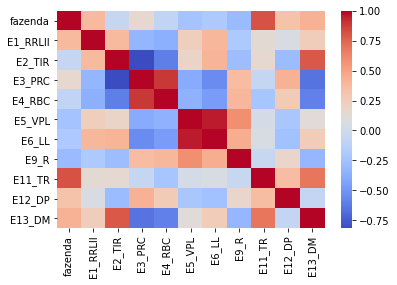

In [7]:
#smaller chart
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [8]:
#check which ones are statiscally significant
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_cultivo)



In [9]:
#Plot p-values
def highlight_significant(val):
    '''
    highlight in blue only the statistically significant cells
    '''
    color = 'blue' if val < 0.05 else 'grey'
    return 'color: %s' % color

p_values.style.applymap(highlight_significant)

,fazenda,E1_RRLII,E2_TIR,E3_PRC,E4_RBC,E5_VPL,E6_LL,E9_R,E11_TR,E12_DP,E13_DM
fazenda,0.000000,0.225400,0.876500,0.623300,0.801300,0.449800,0.545000,0.357600,0.001200,0.291600,0.167800
E1_RRLII,0.225400,0.000000,0.222900,0.306800,0.237100,0.447200,0.194500,0.557600,0.675800,0.859300,0.435400
E2_TIR,0.876500,0.222900,0.000000,0.001200,0.039400,0.537800,0.182500,0.377100,0.638400,0.364400,0.001900
E3_PRC,0.623300,0.306800,0.001200,0.000000,0.000100,0.214500,0.066100,0.237600,0.850400,0.167900,0.022100
E4_RBC,0.801300,0.237100,0.039400,0.000100,0.000000,0.259000,0.130200,0.200500,0.484600,0.392900,0.042700
E5_VPL,0.449800,0.447200,0.537800,0.214500,0.259000,0.000000,0.000000,0.042800,0.914900,0.504800,0.713300
E6_LL,0.545000,0.194500,0.182500,0.066100,0.130200,0.000000,0.000000,0.142600,0.869300,0.429400,0.402100
E9_R,0.357600,0.557600,0.377100,0.237600,0.200500,0.042800,0.142600,0.000000,0.879500,0.571600,0.315900
E11_TR,0.001200,0.675800,0.638400,0.850400,0.484600,0.914900,0.869300,0.879500,0.000000,0.247800,0.013400
E12_DP,0.291600,0.859300,0.364400,0.167900,0.392900,0.504800,0.429400,0.571600,0.247800,0.000000,0.831100


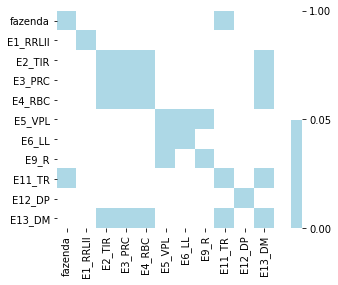

In [10]:
#Smaller plot of p-values
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap_discrete = colors.ListedColormap(['lightblue', 'white'])
bounds=[0,0.05,1]
norm_binary = colors.BoundaryNorm(bounds, cmap_discrete.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap_discrete, norm=norm_binary)

sns.heatmap(p_values, xticklabels=p_values.columns, yticklabels=p_values.columns, cmap=cmap_discrete, norm=norm_binary)

**PCA** 
Now we do the PCA 

In [11]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)


In [12]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_cultivo[['fazenda']]], axis = 1)

[ 1  2  3  4  5  6  7  8 10 11 12 13]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


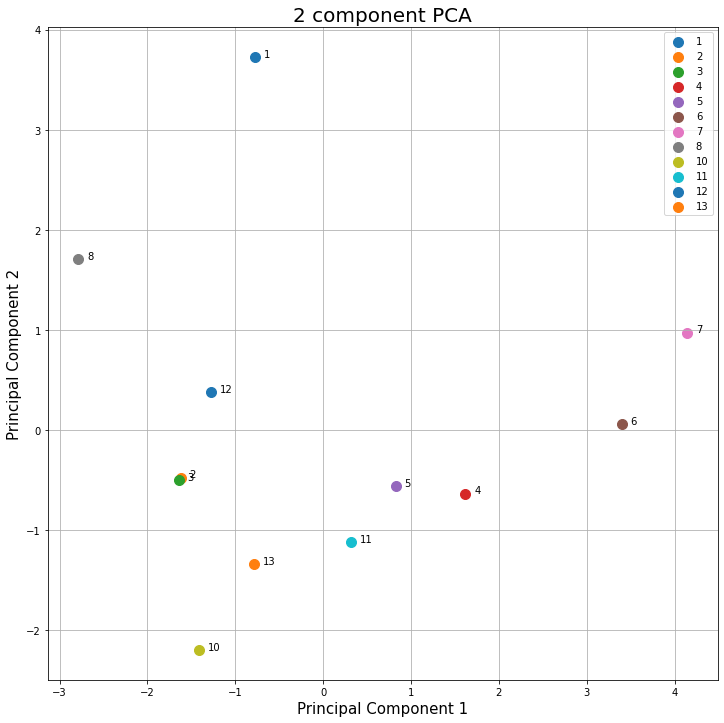

In [13]:
#Visualize results of PCA in Two Dimensions
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = df_cultivo['fazenda'].to_numpy()
print(targets)
for target in targets:
    indicesToKeep = finalDf['fazenda'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x,y,s = 100)
    ax.annotate(target, (x+0.1,y))

#for name in targets:  
    
ax.legend(targets, loc='top right')
ax.grid()

In [14]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))


variance explained by each component: [0.41714191 0.22495845]
total variance explained: 0.6421003596886915


In [15]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'fazenda': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1])}, columns=['fazenda', 'pc1','pc2'])
#df_clustering

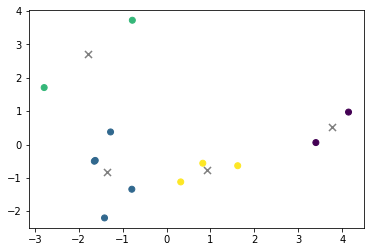

In [16]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker="x", color="grey"); # Show the 


In [17]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,fazenda,pc1,pc2,cluster
5,6,3.398649,0.058140,0
6,7,4.142030,0.972346,0
1,2,-1.622970,-0.477475,1
2,3,-1.643715,-0.501734,1
8,10,-1.411833,-2.201416,1
10,12,-1.274268,0.376599,1
11,13,-0.790367,-1.341184,1
0,1,-0.778707,3.726350,2
7,8,-2.785507,1.707594,2
3,4,1.619379,-0.635899,3


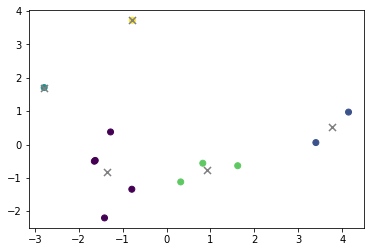

In [18]:
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker="x", color="grey"); # Show the 


In my view, we have two large clusters and three outliers, as the graph above shows.

In [19]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,fazenda,pc1,pc2,cluster
1,2,-1.622970,-0.477475,0
2,3,-1.643715,-0.501734,0
8,10,-1.411833,-2.201416,0
10,12,-1.274268,0.376599,0
11,13,-0.790367,-1.341184,0
5,6,3.398649,0.058140,1
6,7,4.142030,0.972346,1
7,8,-2.785507,1.707594,2
3,4,1.619379,-0.635899,3
4,5,0.824927,-0.561561,3


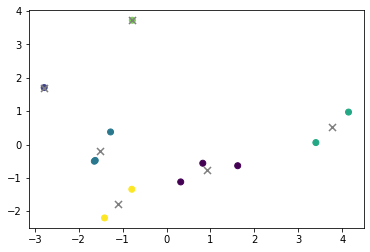

In [20]:
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker="x", color="grey"); # Show the 


In [21]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,fazenda,pc1,pc2,cluster
3,4,1.619379,-0.635899,0
4,5,0.824927,-0.561561,0
9,11,0.322381,-1.121761,0
7,8,-2.785507,1.707594,1
1,2,-1.622970,-0.477475,2
2,3,-1.643715,-0.501734,2
10,12,-1.274268,0.376599,2
5,6,3.398649,0.058140,3
6,7,4.142030,0.972346,3
0,1,-0.778707,3.726350,4


Now we analyze 3 Principal Components


In [22]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)

In [26]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df_cultivo[['fazenda']]], axis = 1)

In [27]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))

variance explained by each component: [0.41714191 0.22495845 0.15992274]
total variance explained: 0.8020230985323334


Now we search for clusters for 3 principal components

In [28]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'fazenda': targets,  'pc1':list(principalComponents[:,0]),
                              'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])},
                              columns=['fazenda', 'pc1','pc2','pc3'])
#df_clustering

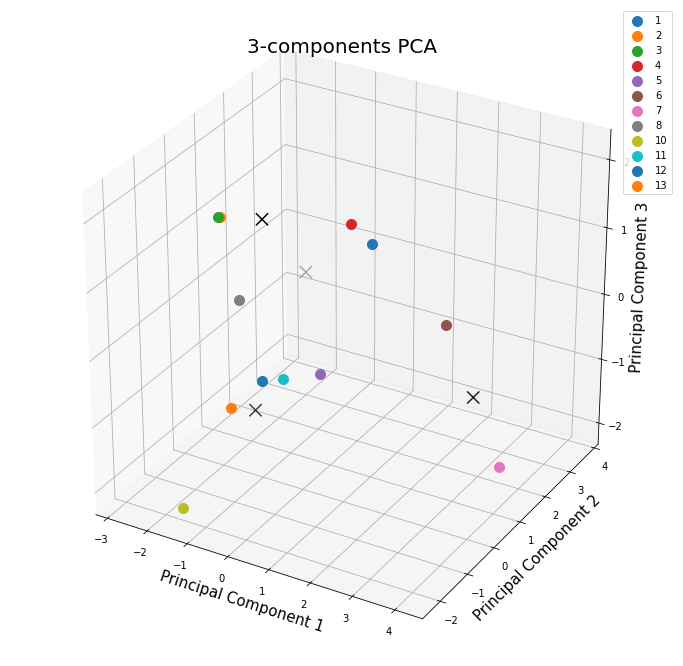

In [30]:
#4 clusters 
from sklearn.cluster import KMeans
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['fazenda'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['fazenda'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 
    
ax.legend(targets)
ax.grid()

Now we search for clusters for the 3 principal components

In [31]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')


,fazenda,pc1,pc2,pc3,cluster
5,6,3.398649,0.058140,0.750746,0
6,7,4.142030,0.972346,-1.573919,0
1,2,-1.622970,-0.477475,1.663509,1
2,3,-1.643715,-0.501734,1.669400,1
3,4,1.619379,-0.635899,2.137166,1
4,5,0.824927,-0.561561,-0.197224,2
8,10,-1.411833,-2.201416,-2.030523,2
9,11,0.322381,-1.121761,-0.160113,2
10,12,-1.274268,0.376599,-1.030073,2
11,13,-0.790367,-1.341184,-0.721947,2


Comparing k-means of PC12 with PC123, we see that the cluster membership changes completely.

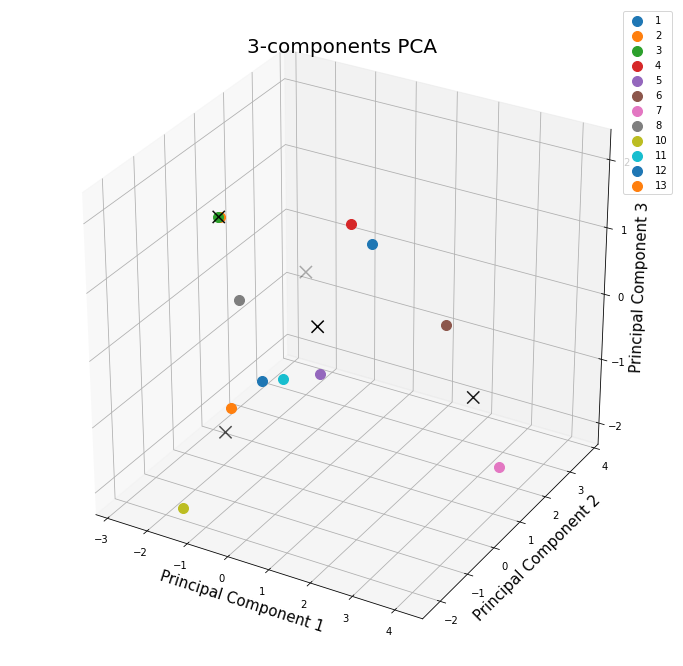

In [32]:
#5 clusters 
from sklearn.cluster import KMeans
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['fazenda'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['fazenda'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [33]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,fazenda,pc1,pc2,pc3,cluster
1,2,-1.622970,-0.477475,1.663509,0
2,3,-1.643715,-0.501734,1.669400,0
5,6,3.398649,0.058140,0.750746,1
6,7,4.142030,0.972346,-1.573919,1
8,10,-1.411833,-2.201416,-2.030523,2
10,12,-1.274268,0.376599,-1.030073,2
11,13,-0.790367,-1.341184,-0.721947,2
0,1,-0.778707,3.726350,0.001344,3
7,8,-2.785507,1.707594,-0.508368,3
3,4,1.619379,-0.635899,2.137166,4


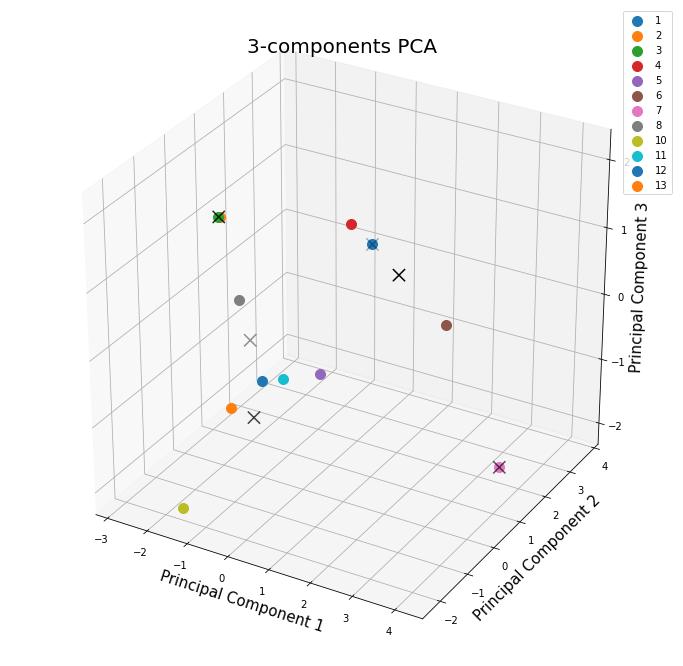

In [34]:
#6 clusters 
from sklearn.cluster import KMeans
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['fazenda'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['fazenda'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [35]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,fazenda,pc1,pc2,pc3,cluster
4,5,0.824927,-0.561561,-0.197224,0
8,10,-1.411833,-2.201416,-2.030523,0
9,11,0.322381,-1.121761,-0.160113,0
11,13,-0.790367,-1.341184,-0.721947,0
0,1,-0.778707,3.726350,0.001344,1
3,4,1.619379,-0.635899,2.137166,2
5,6,3.398649,0.058140,0.750746,2
7,8,-2.785507,1.707594,-0.508368,3
10,12,-1.274268,0.376599,-1.030073,3
6,7,4.142030,0.972346,-1.573919,4
